## EDA

In [90]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from collections import defaultdict
import pickle as pl
import math
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)

In [91]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
import os

In [92]:
import warnings
warnings.filterwarnings("ignore")

In [93]:
df = pd.read_csv('papermodeldata(in).csv')

In [94]:
len(df.columns) -5 

51

In [95]:
df['ttd'].isnull().any()
df['fold'].isnull().any()
df['time'].isnull().any()
df['y'].isnull().any()

np.False_

In [96]:
count_labels = df['y'].groupby(df['y']).count()
count_labels[1]/count_labels[0]*100

np.float64(0.6785127250348604)

In [97]:
df['VitalID'].groupby(df['VitalID']).count()

VitalID
1005     12
1007    138
1010    267
1011     53
1013    103
       ... 
8769     13
8770      6
8771      4
8772      8
8773      4
Name: VitalID, Length: 5957, dtype: int64

In [98]:
df_dead = df[df['y'] == 1]
df_alive = df[df['y'] == 0]

In [99]:
df_alive['VitalID'].groupby(df_alive['VitalID']).count()

VitalID
1005     12
1007    138
1010    265
1011     53
1013     98
       ... 
8769     13
8770      6
8771      4
8772      8
8773      4
Name: VitalID, Length: 5948, dtype: int64

In [100]:
df_dead['VitalID'].groupby(df_dead['VitalID']).count()

VitalID
1010    2
1013    5
1017    7
1028    3
1031    3
       ..
8364    2
8501    1
8510    2
8521    3
8549    5
Name: VitalID, Length: 219, dtype: int64

In [101]:
count_folds = df.groupby(['fold','y']).size()
first = None
second = None
count = 0
for i in count_folds:
    count+=1
    if not(first):
        first = i
    else:
        second = i

    if(count==2):
        count = 0
        print((second/first)*100)
        first = None 
        second = None
    

0.674415267613718
0.5912786400591279
0.5741482208959734
0.7453205725417126
0.5463627848891663
0.7854225573358466
0.8354916868577157
0.5309466019417476
0.6714517249363279
0.8686388592968943


In [102]:
df_dropped = df.drop(['VitalID', 'time','fold','ttd'], axis=1)
df_na_dropped = df_dropped.dropna()
df_dead = df_dropped[df_dropped['y'] == 1]
df_alive = df_dropped[df_dropped['y'] == 0]
df_dead_na_dropped = df_na_dropped[df_na_dropped['y'] == 1]
df_alive_na_dropped = df_na_dropped[df_na_dropped['y'] == 0]

In [103]:
print(((len(df_dead)- len(df_dead_na_dropped)) /len(df_dead)) * 100)
print(((len(df_alive) - len(df_alive_na_dropped)) /len(df_alive))*100)

1.6073478760045925
2.0324221579976474


## Data Preparation

In [104]:
# keep the y seprate 
# remove nan values 
# remove duplicate values

In [105]:
# what if baby remained ill for a long time until his/her death.

In [106]:
# if ttd is there , that means the baby is eventually going to die..
# if ttd<=days , put y = 1
# if ttd>days  , put y =0
def format_y(no_of_days,ttd,y_values):
    for index in range(len(ttd)):
        if(ttd[index]<=no_of_days):
            y_values[index] = 1
        else:
            y_values[index] = 0
    return y_values

In [107]:
from scipy.stats.mstats import winsorize
def winsorize_col(column):
    return winsorize(column, limits=(0.001, .001))

def winsorize_df(df):
    return df.apply(winsorize_col,axis=0)

In [108]:
def create_df(df,days):
    ttd = df['ttd']
    y_arr = df['y']
    y_arr = format_y(days,ttd,y_arr)
    df['y'] = y_arr
    # change the y column in the df to the y_arr

    # we only care if the trainign data colun values contain NaN values 
    df_drop_col = df.drop(['VitalID','ttd','time'], axis=1)
    df_drop_col_dup = df_drop_col.drop_duplicates()
    df_drop_col_dup_na = df_drop_col_dup.dropna()

    y_arr = df_drop_col_dup_na['y']
    fold_arr = df_drop_col_dup_na['fold']

    df_drop_col_dup_na.drop(['y','fold'], axis=1,inplace=True)
    df = winsorize_df(df_drop_col_dup_na)
    return df,fold_arr,y_arr

In [109]:
Basics = [ "VitalID","time","fold","ttd","y"]

Demographics = ['bwt', 'ega', 'male', 'apgar5']

HR = ['HR.SB.MotifTwo.diff.uu', 'HR.SB.MotifTwo.diff.uuu','HR.ST.LocalExtrema.l25.diffmaxabsmin', 'HR.std','HR.SB.MotifThree.diffquant.hhhh',
       'HR.EX.MovingThreshold.a0.25.b0.1.meanqover', 'HR.DN.cv.3','HR.SB.MotifTwo.iqr.ddd','HR.SY.StdNthDer.5','HR.ST.LocalExtrema.l25.maxmaxmed', 'HR.SY.StdNthDer.17', 'HR.Quantile.99', 'HR.FC.Suprise.tstat',
       'HR.SB.MotifThree.quantile.hhhh','HR.EX.MovingThreshold.a0.25.b0.05.meanqover','HR.PH.Walkerrunningvar...sw.meanabsdiff', 'HR.CO.tc3.1..denom', 'HR.mean',
       'HR.skew2','HR.SB.TransitionMatrix23.sumdiagcov','HR.ST.LocalExtrema.n100.minabsmin', 'HR.kurt2', 'HR.MF.arfit.sbc.7'
       ]

SPO2 = [ 'SP.EX.MovingThreshold.a0.25.b0.1.meanqover', 'SP.EX.MovingThreshold.a1.b0.25.iqrq', 'SP.PH.Walkerbiasprop.0.1..0.5..sw.meanabsdiff',
'SP.EX.MovingThreshold.a0.25.b0.1.maxq', 'SP.PH.Walkerprop.0.9..w.std', 'SP.skew2','SP.SB.MotifTwo.diff.dduu','SP.DN.RemovePointsmin.0.2.mean',
'SP.PH.Walkermomentum.2..sw.stdrat','SP.CO.tc3.1..denom','SP.mean','SP.kurt2', 'SP.SB.MotifThree.diffquant.hhh','SP.SB.MotifTwo.mean.dddd',
'SP.AutoCorr.lag.4','SP.SB.TransitionMatrix41.ondiag', 'SP.SB.MotifThree.quantile.baaa','SP.std', 'SP.SB.TransitionMatrix21.T10', 'SP.SB.BinaryMethod.iqr.pstretch1'
,'SP.PH.Walkerprop.0.9..sw.stdrat','SP.MF.arfit.sbc.7','SP.SB.TransitionMatrix22.mineig','SP.ST.LocalExtrema.n100.minabsmin']

In [110]:
def create_diff_dfs(df):
    df_hr = df[Basics + HR]
    df_spo2 = df[Basics + SPO2]
    df_demographics = df[Basics + Demographics]
    df_hr_spo2 = df[Basics + HR + SPO2] 
    df_hr_spo2_demographics = df[Basics + HR + SPO2 + Demographics]
    return [df_hr,df_spo2,df_demographics,df_hr_spo2,df_hr_spo2_demographics]

In [111]:
[df_hr,df_spo2,df_demographics,df_hr_spo2,df_hr_spo2_demographics] = create_diff_dfs(df)

In [112]:
for i in [df_hr,df_spo2,df_demographics,df_hr_spo2,df_hr_spo2_demographics]:
    print(i.groupby(['fold', 'y']).agg(Count=("VitalID","count")).reset_index())
    print("\n\n\n")

    fold  y  Count
0      1  0  13938
1      1  1     94
2      2  0  13530
3      2  1     80
4      3  0  13237
5      3  1     76
6      4  0  11807
7      4  1     88
8      5  0  12812
9      5  1     70
10     6  0  12732
11     6  1    100
12     7  0  11969
13     7  1    100
14     8  0  13184
15     8  1     70
16     9  0  12957
17     9  1     87
18    10  0  12203
19    10  1    106




    fold  y  Count
0      1  0  13938
1      1  1     94
2      2  0  13530
3      2  1     80
4      3  0  13237
5      3  1     76
6      4  0  11807
7      4  1     88
8      5  0  12812
9      5  1     70
10     6  0  12732
11     6  1    100
12     7  0  11969
13     7  1    100
14     8  0  13184
15     8  1     70
16     9  0  12957
17     9  1     87
18    10  0  12203
19    10  1    106




    fold  y  Count
0      1  0  13938
1      1  1     94
2      2  0  13530
3      2  1     80
4      3  0  13237
5      3  1     76
6      4  0  11807
7      4  1     88
8      5  0  12812
9   

In [113]:
# while (curr_no_of_features(variable) >= 5)
    # for the different no of folds(variable)
        # take only that fold dataset from the df(variable) and its corresponding y for validation 
        # the rest of the data will be used to train the model

        # fit the model 
        # do the inference on the hold out set 
        # store the cv accuracy score 

        # call the permuation_importance function and provide the fitted model and hold out set as arguments 
        # store the feature importance of all the features 

    # average out the feature importance across the folds and get the argmin 
    # store the no of features 
    # store the average of the cv scores
    # store the standard deviation of the cv scores

    # no_of_features to decrease = min(5,curr_no_features-5)
    # if(no_of_features to decrease):
    #      break
    # remove the features from the dataset and continue with the changed dataset 

# Arguments: df(the dataset features), fold_arr, y_arr

In [114]:
# have uniform logits
# write modular code 
# look at internet examples   

In [126]:
no_of_logits = 100
base_logit = 1/no_of_logits
logits_arr = sorted([base_logit*i for i in range(1,no_of_logits+1)])[::-1]

In [128]:
def give_results(df,fold_arr: list,y_arr: list,decrement: int,lower_bound: int,max_iters: int):
    results = defaultdict(list)
    folds = sorted(fold_arr.unique())
    curr_features = list(df.columns)

    while len(curr_features) >= lower_bound:
        cv_scores = []
        feature_importances = []
        roc_auc_scores = []
        auprc_scores = []

        precisions_arr = []
        recalls_arr = []
        false_positive_rates_arr = []

        print("Current features: " + str(len(curr_features)))

        for fold_val in folds:

            # Split data
            X_val = df[fold_arr == fold_val][curr_features].to_numpy()
            y_val = y_arr[fold_arr == fold_val].to_numpy()

            X_train = df[fold_arr != fold_val][curr_features].to_numpy()
            y_train = y_arr[fold_arr != fold_val].to_numpy()

            # Fit model
            model = LogisticRegression(max_iter=max_iters).fit(X_train, y_train)

            # get the test out set scores
            y_pred = model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            cv_scores.append(acc)

            # Permutation importance
            perm = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42)
            feature_importances.append(perm.importances_mean)

            # Get the probability estimates for the positive class
            y_scores = model.predict_proba(X_val)[:, 1]
            
            precision, recall, _ = precision_recall_curve(y_val,y_scores)
            disp = PrecisionRecallDisplay(precision=precision, recall=recall)
            disp.plot()

            roc_auc_scores.append(roc_auc_score(y_val,y_scores))
            auprc_scores.append(average_precision_score(y_val, y_scores))

            recall_arr = []
            precision_arr = []
            false_positive_rate_arr = []
            y_val = np.array(y_val)

            for logit in logits_arr:

                y_scores_pred = np.array(y_scores) > logit
                true_positives = sum(np.logical_and(y_scores_pred==1,y_val==1))
                false_negatives = sum(np.logical_and(y_scores_pred == 0, y_val==1))
                false_positives = sum(np.logical_and(y_scores_pred == 1, y_val==0))
                true_negatives = sum(np.logical_and(y_scores_pred==0,y_val==0))

                recall = true_positives/(true_positives+false_negatives)
                precision = true_positives/(true_positives+false_positives)
                fpr = false_positives/(false_positives+true_negatives)

                if(math.isnan(precision)):
                    precision_arr.append(1)
                else:
                    precision_arr.append(precision)

                recall_arr.append(recall)
                false_positive_rate_arr.append(fpr)

            recalls_arr.append(recall_arr)
            precisions_arr.append(precision_arr)
            false_positive_rates_arr.append(false_positive_rate_arr)


        # Store results
        results['num_features'].append(len(curr_features))
        results['cv_score_mean'].append(np.mean(cv_scores))
        results['cv_score_std'].append(np.std(cv_scores))
        results['roc_auc_score'].append(np.mean(roc_auc_scores))
        results['aurpc_score'].append(np.mean(auprc_scores))

        recalls_arr_mean = np.mean(recalls_arr,axis =0)  # true postive rate = recall
        precisions_arr_mean = np.mean(precisions_arr,axis =0)
        false_positive_rates_arr_mean = np.mean(false_positive_rates_arr,axis=0)

        recall_arr_std = np.std(recalls_arr,axis=0)
        precision_arr_std = np.std(precisions_arr,axis=0)
        false_positive_rate_arr_std = np.std(false_positive_rates_arr,axis=0)

        results['recalls_arr_mean'].append(recalls_arr_mean)
        results['precisions_arr_mean'].append(precisions_arr_mean)
        results['false_positive_rates_arr_mean'].append(false_positive_rates_arr_mean)
        results['recall_arr_std'].append(recall_arr_std)
        results['precision_arr_std'].append(precision_arr_std)
        results['false_positive_rate_arr_std'].append(false_positive_rate_arr_std)


        # Average feature importance across folds
        avg_importance = np.mean(feature_importances, axis=0)
        # print(avg_importance)

        # Find least important features
        num_to_remove = min(decrement, len(curr_features) - lower_bound)
        
        if num_to_remove == 0:
            break

        remove_idx = np.argsort(avg_importance)[:num_to_remove]
        remove_features = [curr_features[i] for i in remove_idx]

        # Remove features for next iteration
        # works on feature names....have to ensure feature names are different
        curr_features = [f for f in curr_features if f not in remove_features]

    # Convert results to DataFrame for inspection
    return results

Current features: 23
Current features: 18
Current features: 13
Current features: 8
Current features: 5


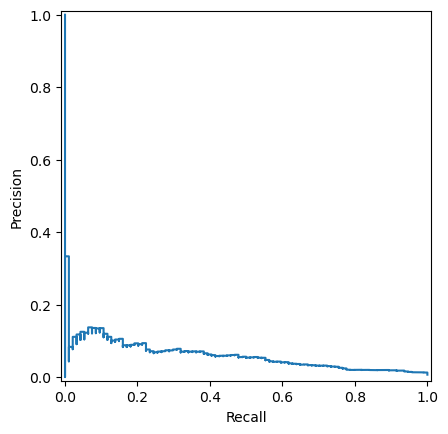

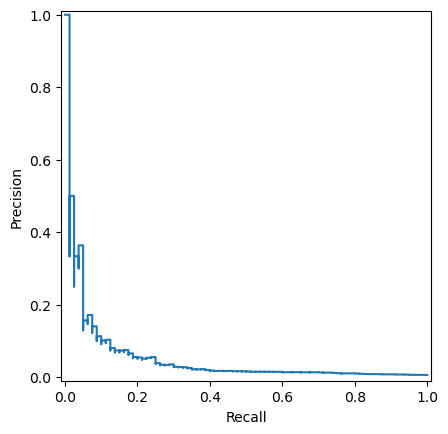

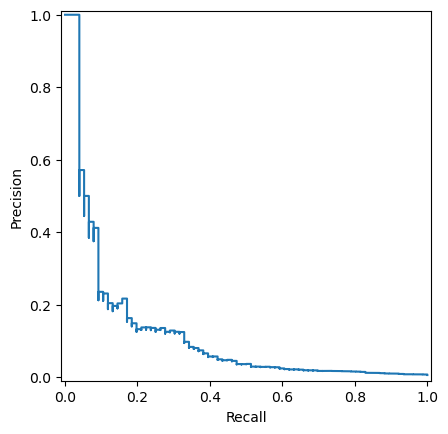

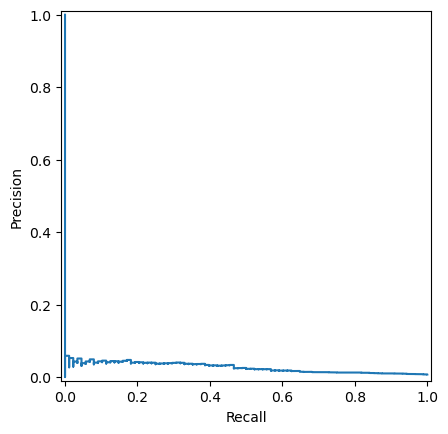

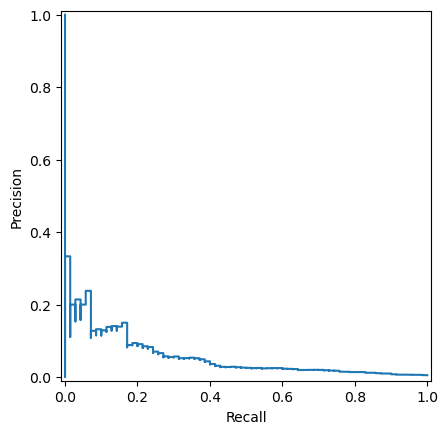

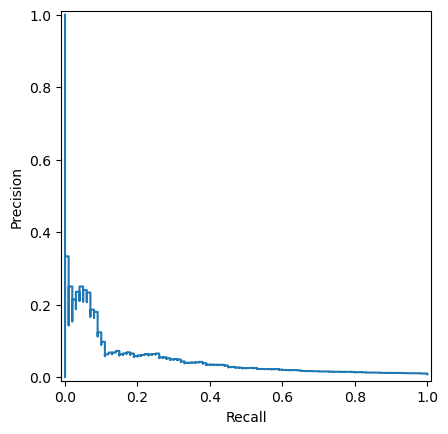

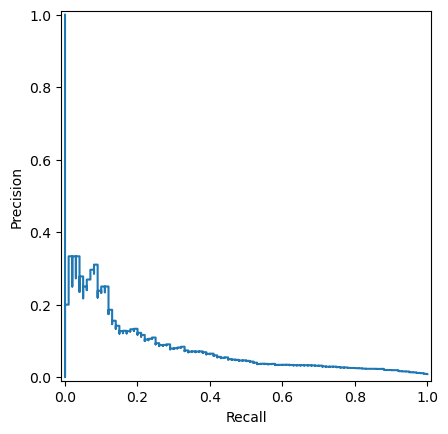

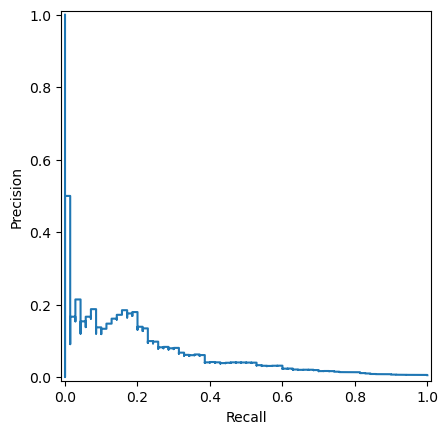

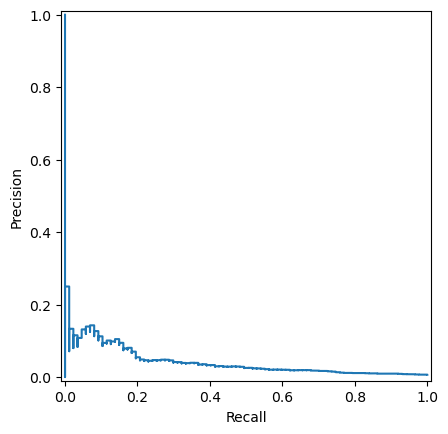

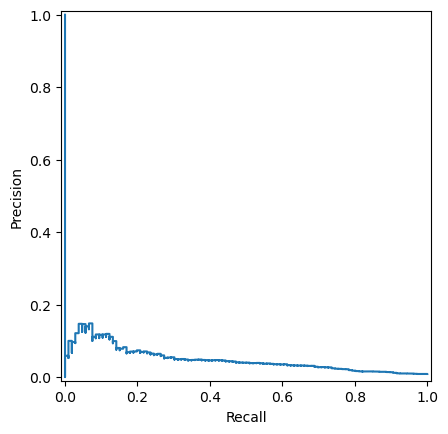

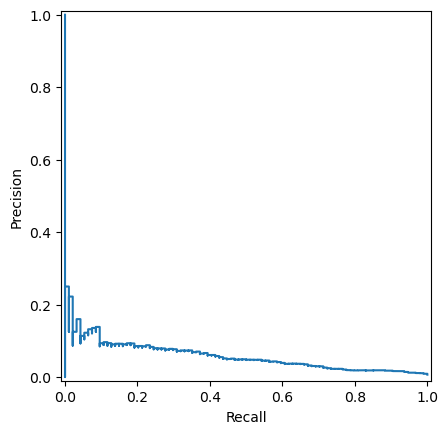

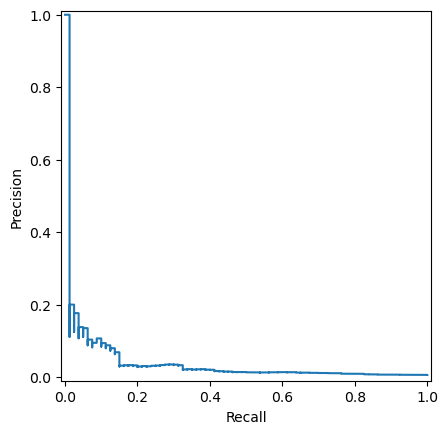

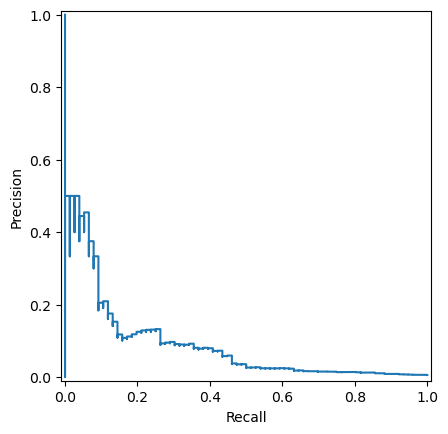

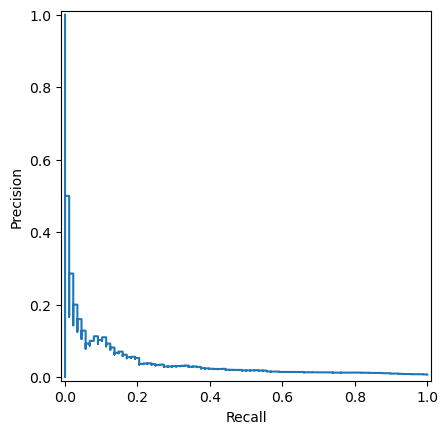

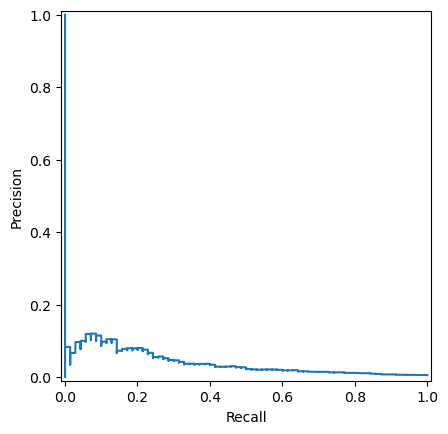

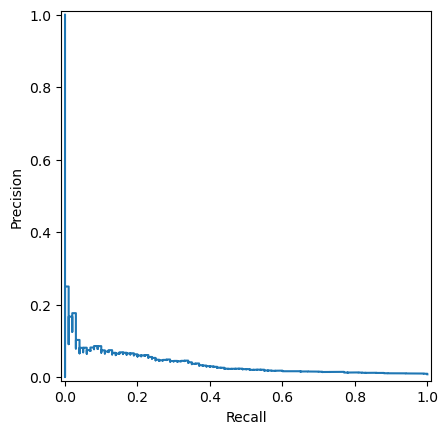

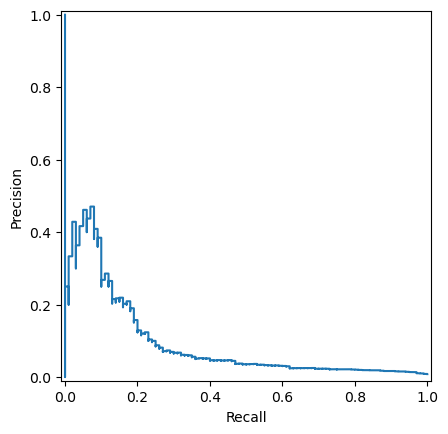

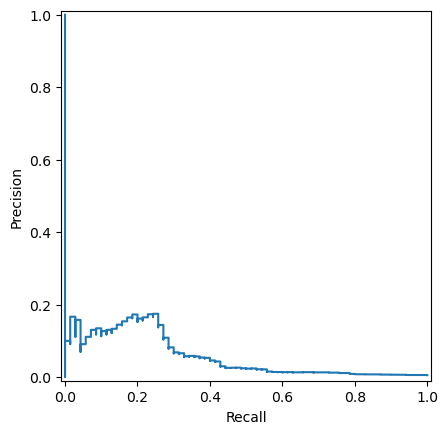

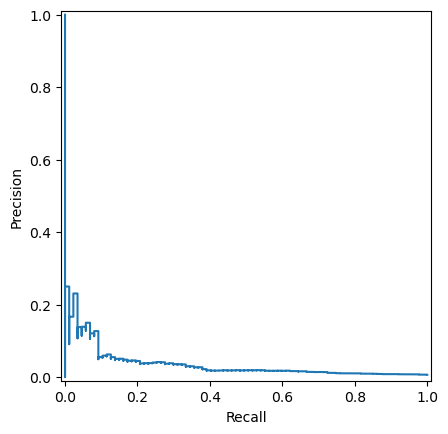

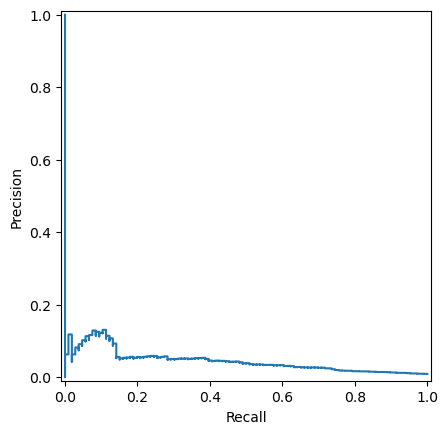

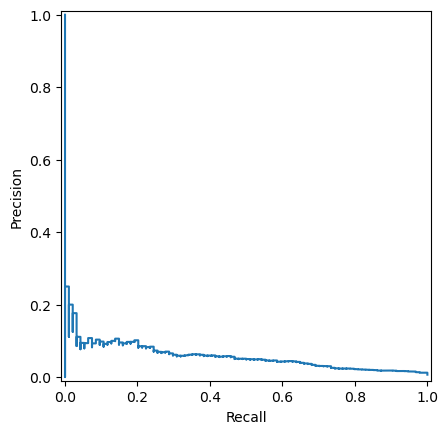

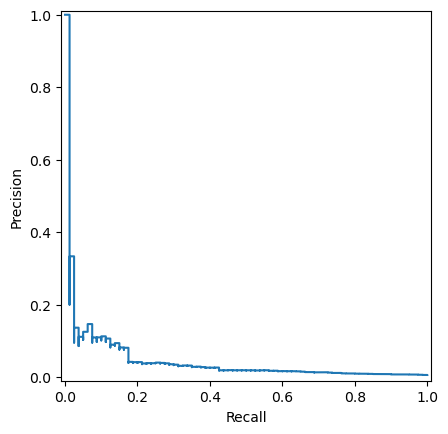

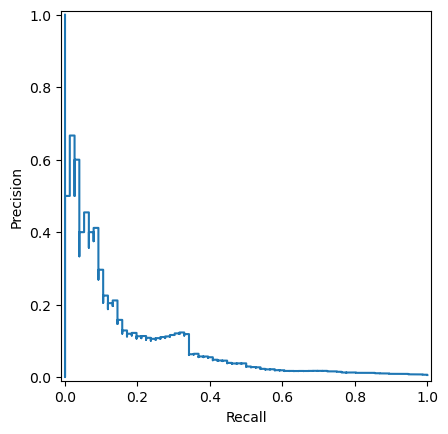

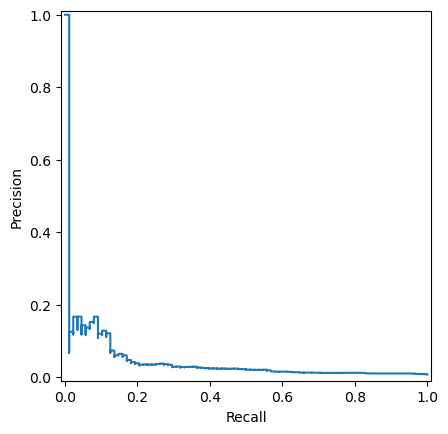

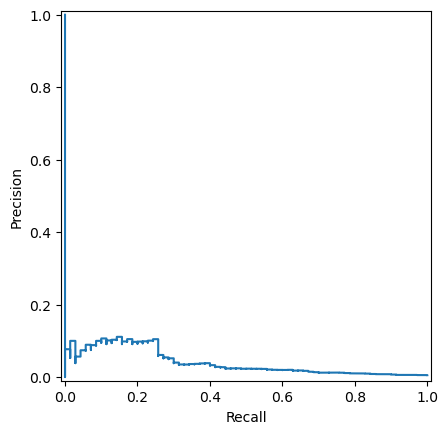

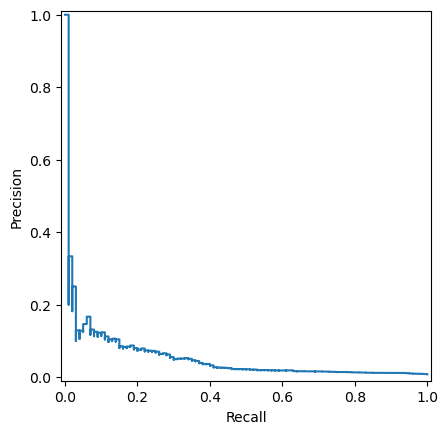

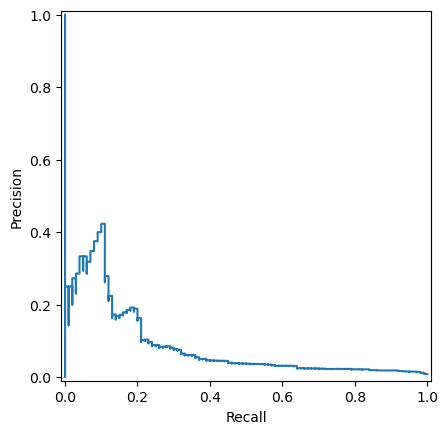

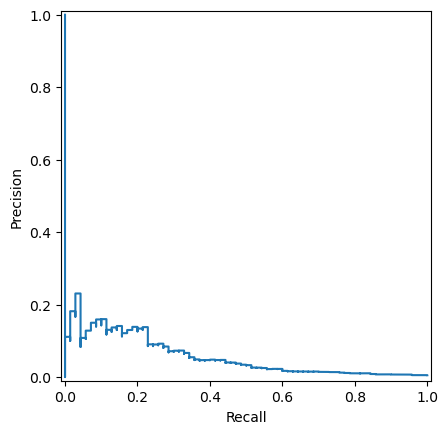

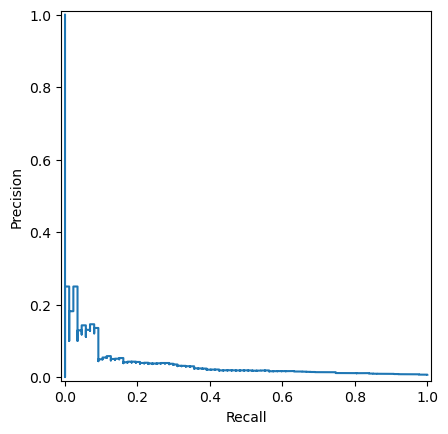

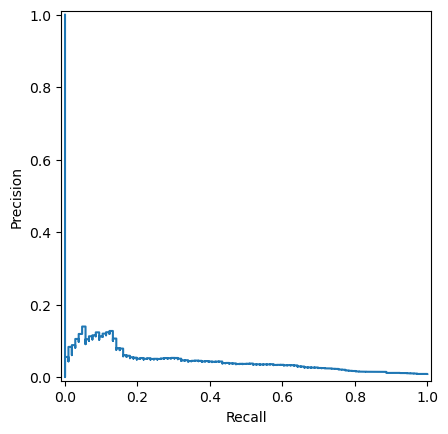

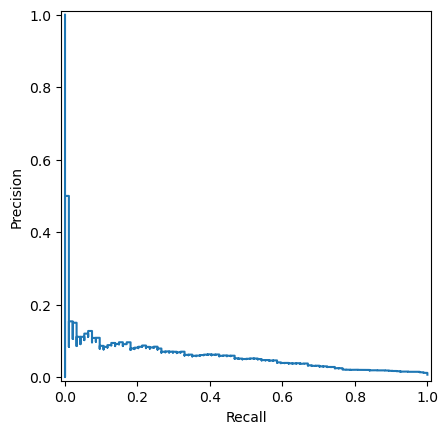

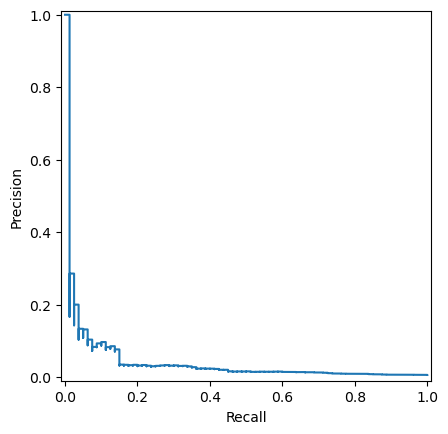

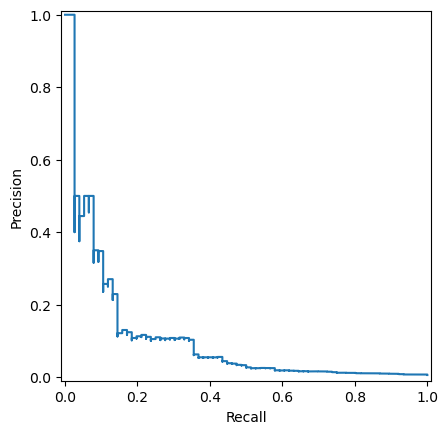

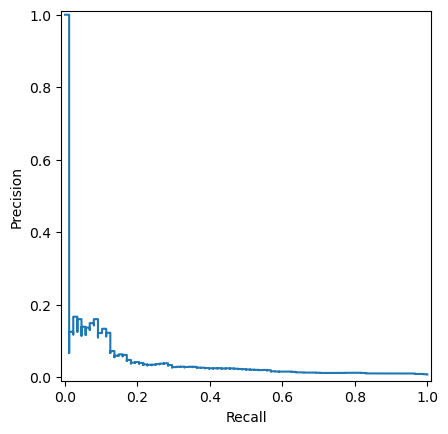

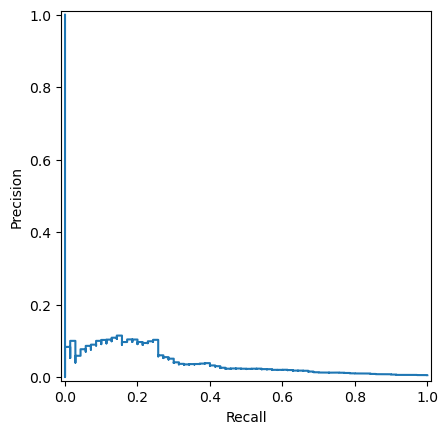

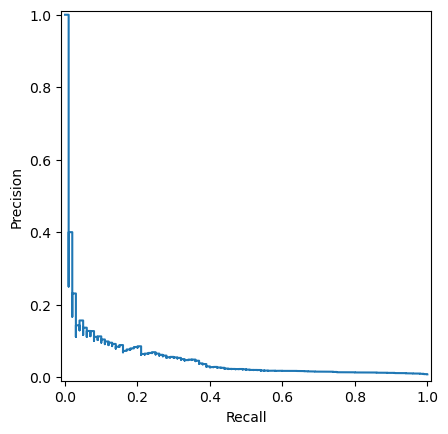

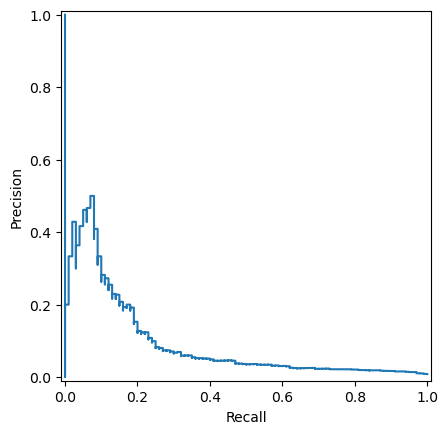

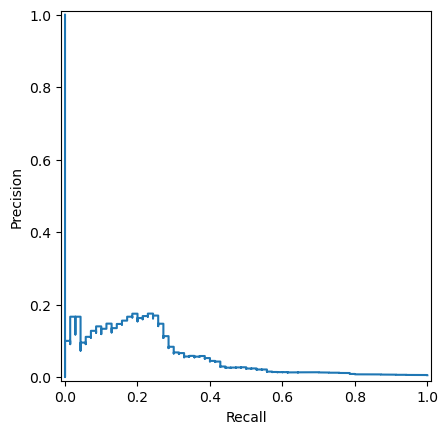

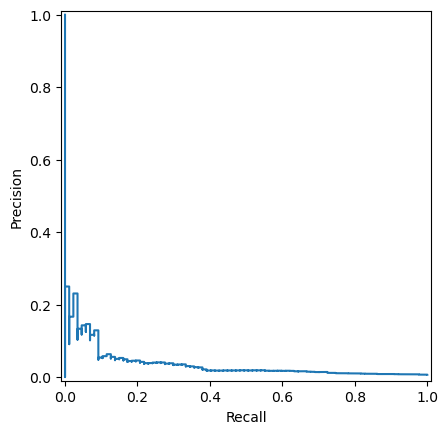

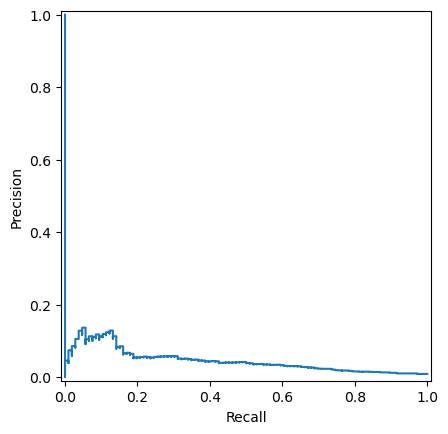

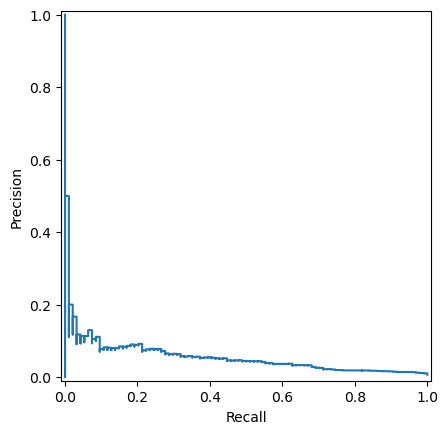

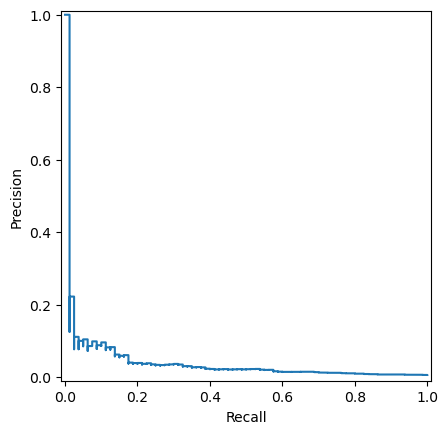

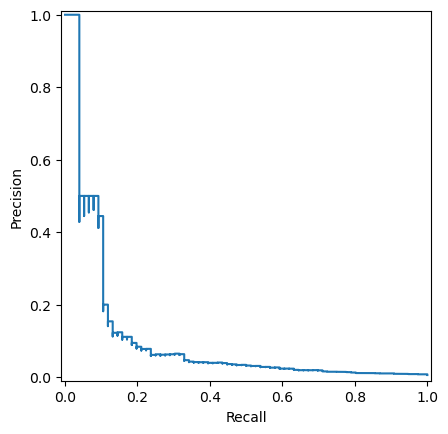

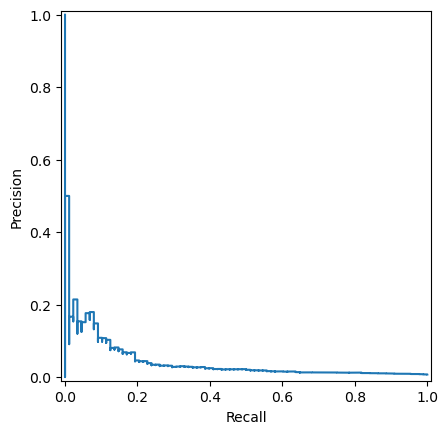

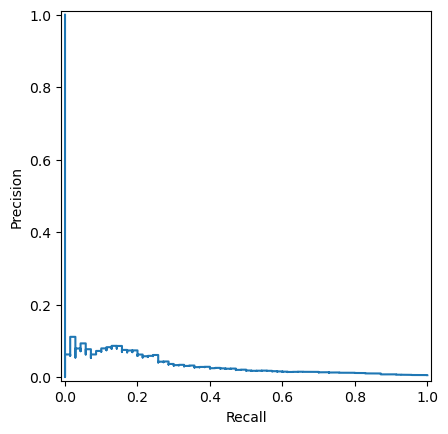

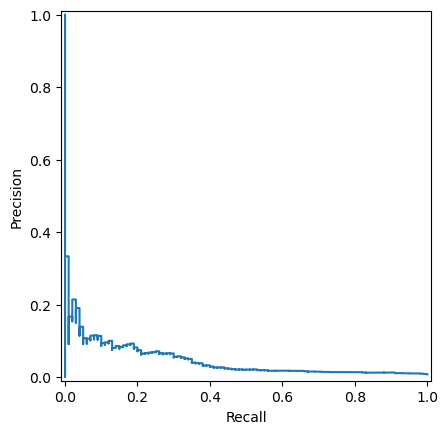

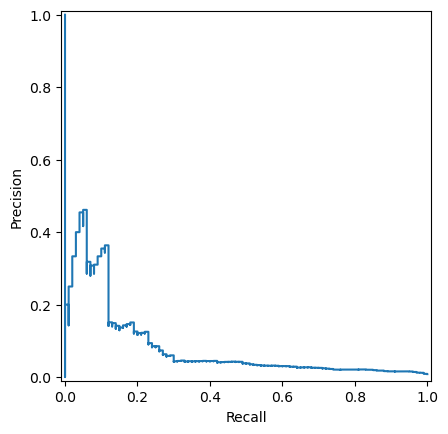

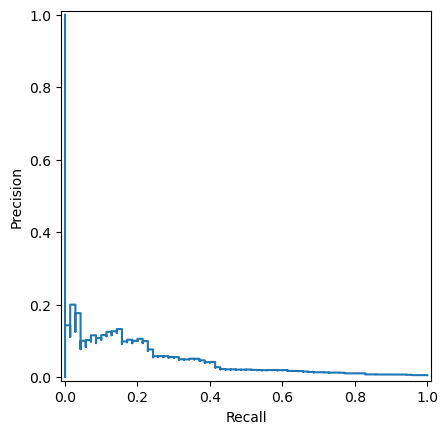

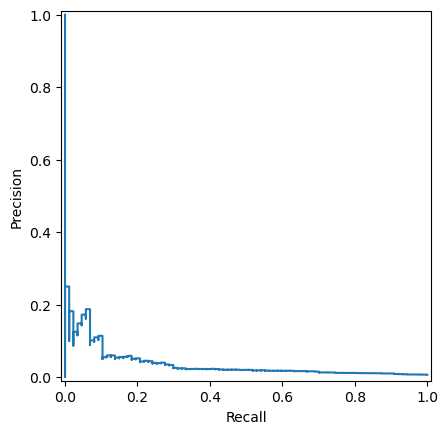

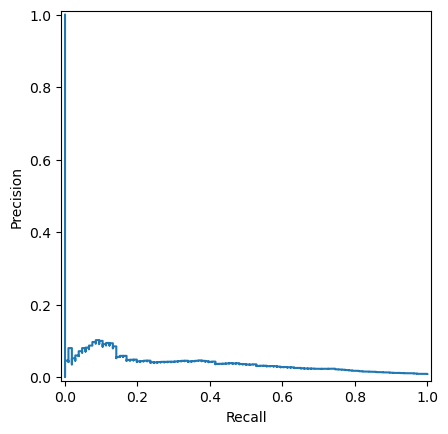

In [129]:
days = [7,3,1]
dfs_arr = create_diff_dfs(df)
results_dict = defaultdict(list)
no_of_model_features = [5,5,4,5,6] # specifying the lower bound
decrement = 5  # specifying the no of features to decrement by every time

for day in days: 
    for dataframe_index in range(len(dfs_arr)):
        data,fold_arr,y_arr = create_df(dfs_arr[dataframe_index],day)
        results = give_results(data,fold_arr,y_arr,decrement,no_of_model_features[dataframe_index],2000)
        results_dict[day].append(results)
        break
    break

In [87]:
with open('./results2.pkl', 'rb') as f:
        # Load the data from the pickle file
        loaded_data = pl.load(f)

In [88]:
output_dir = '/Users/adityagoyal/Desktop/Research - yin li/baseline/results2'

# Create the directory if it doesn't exist
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
    
for day in days: 
    # create dir for day
    
    output_dir = '/Users/adityagoyal/Desktop/Research - yin li/baseline/results2'
    filename = f"Day: {day}"
    filepath = os.path.join(output_dir, filename)
    if not os.path.isdir(filepath):
        os.makedirs(filepath)
    
    
    for dataframe_index in range(len(dfs_arr)):
        
        # create dir for dataframe_index..this is the last dir
        output_dir = f'/Users/adityagoyal/Desktop/Research - yin li/baseline/results2/Day: {day}'
        filename = f"df: {dataframe_index}"
        filepath = os.path.join(output_dir, filename)
        if not os.path.isdir(filepath):
            os.makedirs(filepath)
        
        
        result = loaded_data[day][dataframe_index]

        x_precision = np.array(result['precisions_arr_mean'])
        x_recall = np.array(result['recalls_arr_mean'])
        x_fpr = np.array(result['false_positive_rates_arr_mean'])
        
        x_precision_std = np.array(result['precision_arr_std'])
        x_recall_std = np.array(result['recall_arr_std'])
        x_fpr_std = np.array(result['false_positive_rate_arr_std'])
        
        

        plt.plot(x_recall,x_precision, color="blue")
        # plt.scatter(x_recall,x_precision, color="blue",alpha=0.3,s=5)
        plt.xlim(0,1)
        plt.ylim(0,1)
        lower = np.maximum(x_precision - x_precision_std, 0.0).reshape(-1)
        upper = np.minimum(x_precision + x_precision_std, 1.0).reshape(-1)
        plt.fill_between(x_recall.reshape(-1), lower, upper, alpha=0.3,color='0.8')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.title("Precision Recall curve")
        plt.savefig(f"{filepath}/PR curve.png", dpi=300, bbox_inches="tight")
        plt.close()


        plt.plot(x_fpr,x_recall, color="blue")
        # plt.scatter(x_fpr,x_recall, color="blue",alpha=0.3,s=5)
        plt.xlim(0,1)
        plt.ylim(0,1)
        lower = np.maximum(x_recall - x_recall_std, 0.0).reshape(-1)
        upper = np.minimum(x_recall + x_recall_std, 1.0).reshape(-1)
        plt.fill_between(x_fpr.reshape(-1), lower, upper, alpha=0.3,color='0.8')
        plt.xlabel("FPR")
        plt.ylabel("Recall")
        plt.legend()
        plt.title("ROC-AUC curve")
        plt.savefig(f"{filepath}/ROC-AUC curve.png", dpi=300, bbox_inches="tight")
        plt.close()
        break
    break



In [ ]:
# Precision is basically out of all the datapoints you predicted as a class, how much of that is correct.
# Recall is basically, out of all the datapoints belonging to that class, how much were you able to predict correctly.
# You can get this intuition for either of the classes, especially for the imbalanced class 

In [ ]:
# positive and negative are the two classes
# The true positive rate is a measure of the probability that an actual positive instance will be classified as positive.
# The true negative rate is a measure of the probability that an actual negative instance will be classified as negative. 
# he false positive rate is essentially a measure of how often a "false alarm" will occur – or, how often an actual negative instance will be classified as positive. (actually this metric says inofrmation aboput the other class!!!!)

In [ ]:
# precision = tp/(tp+fp)
# recall = tp/(tp + fn)  (also known as the true positive rate)
# f1 = 2*precision*recall/ (precision + recall)

In [ ]:
# when we talk about metrics we talk about only pertaining to one class
# true positive rate = tp/(tp + fn) 
# false positive rate = fp(falsely predicted negative datapoints)/fp+tn (all the negative datapoints)

In [ ]:
# Your use case determines how much importance you give to partiuclar evaluation metrics and which evluation metrics you use and on which class - the 0 or the 1

In [ ]:
# for each fold(hold out set): 
    # Get the predicted logits
    # figure out the different values of the boundary logits (from 0 to 1) say k (like randomly generate unformly spaced values)
    # get the precision recall values for each of the boundary logits 

# average out the precision scores at a particualr boundary logit across the various folds 
# average out the recall scores at a particualr boundary logit across the various folds 
# take the stadnard deviation of the precision socres at a particualr boundary logit across the various folds 
# take the stadnard deviation of the recall socres at a particualr boundary logit across the various folds 

# shape of the precision scores: (folds,k)
# shape of the recall curves: (folds,k)

In [ ]:
# for each fold(hold out set): 
    # Get the predicted logits
    # figure out the different values of the boundary logits (from 0 to 1) say k (like randomly generate unformly spaced values)
    # get the tpr and fpr values for each of the boundary logits 

# average out the tpr socres at a particualr boundary logit across the various folds 
# average out the fpr scores at a particualr boundary logit across the various folds 
# take the stadnard deviation of the tpr socres at a particualr boundary logit across the various folds 
# take the stadnard deviation of the fpr socres at a particualr boundary logit across the various folds 

# shape of the tpr scores: (folds,k)
# shape of the fpr curves: (folds,k)